In [1]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush, nlargest
from ipywidgets import interact, interact_manual
from scipy.special import gamma
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import pairwise_distances
from scipy.stats import multivariate_normal
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import math
import matplotlib

In [2]:
import warnings
import os
warnings.simplefilter('ignore')

os.chdir('/Users/bdemeo/Documents/bergerlab/lsh/ample/bin')
from norms import *
from dataset import *
from datatools import *
os.chdir('/Users/bdemeo/Documents/bergerlab/lsh/ample')

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [4]:
def posterior_cov(xs, prior_cov=None, prior_degs=None, bayesian=True):
    """Given a prior covariance matrix and degrees of freedom, compute posterior covariance matrix
    after seeing xs, matrix of observations (rows) of several variables (cols)
    We assume the prior mean is the sample mean"""
    
    xs = xs.astype(float)
    
    if prior_degs is None: #use the least-informative prior
        prior_degs = xs.shape[1]
        
    N = xs.shape[0] #how many points?
    
    if N <= 1:
        print('single point encountered')
        return(prior_cov) #not enough info to update

    sample_cov = np.cov(np.transpose(xs))
    #print(sample_cov.shape)
    
    if bayesian:
        # see https://www.fil.ion.ucl.ac.uk/~wpenny/publications/bmn.pdf
        posterior_cov = (1./(prior_degs + (float(N)/2.)))*(prior_cov + (float(N)/2.)*sample_cov)
        return(posterior_cov)
    else:
        return(sample_cov)
    
    
    
    
    

In [5]:
def ball_cover(data, n_balls, distfunc):
    """produce an efficient covering by n_balls balls using far traversals"""
    
    balls = {} #dict of {index: neighboring indices}
    rad = float('Inf') #current covering radius
    not_sampled = list(range(data.shape[0]))
    min_dists = [float('Inf')] * data.shape[0]
    
    
    while(len(balls) <= n_balls):
        if len(balls) == 0: #first one, choose center at random
            next_pos = np.random.choice(list(range(len(not_sampled))))
        else:
            next_pos = min_dists.index(rad)
        
        next_center = not_sampled[next_pos]
        balls[next_center] = [(0,next_center)]
        
        del not_sampled[next_pos]
        del min_dists[next_pos]
        
        for pos,ind in enumerate(not_sampled):
            cur_dist = distfunc(data[ind,:],data[next_center,:])
            if cur_dist < rad:
                heappush(balls[next_center], (-1*cur_dist, ind))
            if cur_dist < min_dists[pos]:
                min_dists[pos] = cur_dist
        
        rad = max(min_dists) #update covering radius
        
        for ball in list(balls.keys()):
            pts = balls[ball]
            dist = float('Inf')
            while(dist >= rad):
                furthest_pt = heappop(pts)
                dist = -1*furthest_pt[0]
                      
            
            heappush(pts, furthest_pt) #put back the last one
            balls[ball] = pts
    
        #elim distance info
    balls = {b:[y[1] for y in x] for b,x in balls.items()}
    
    return((balls,rad))
            

In [6]:
def fit(data, n_balls, distfunc, bayesian=True):
    balls, rad = ball_cover(data, n_balls, distfunc)
    
    dims = data.shape[1]
    var = (rad/2.)*(gamma(float(dims)/2.)/(math.sqrt(2)*gamma(float(dims+1)/2.)))
    print(var)
    
    result = []
    for b in balls:
        if bayesian:
            cov = posterior_cov(data[balls[b],:], var * np.identity(dims))
        else:
            cov = np.cov(np.transpose(data[balls[b],:]).astype(float))
            
        result.append((b, data[b,:], cov))
    return(result)

In [7]:
def knn_fit(data, subset, k=5, metric=euclidean, bayesian=False):
    nbhds = knn_cover(data=data, subset=subset, metric=metric, k=k)
    
    result = []
    for n in nbhds:
        cov = np.cov(np.transpose(data[nbhds[n],:]).astype(float))
    
        result.append((n, data[n,:], cov))
    return(result)
    

In [8]:
def random_multigauss(n_gauss, n_pts, dims):
    pts = np.array([]).reshape([0,dims])
    for i in range(n_gauss):
        cov = make_spd_matrix(dims)
        print(cov)
        newpts=np.random.multivariate_normal([0]*dims, cov, size=n_pts)
        
        pts = np.concatenate((pts, newpts), axis=0)
        
    return(pts)
    

In [9]:
def cov_dist(fitvals):
    """from the output of fit, make pairwise covariance distance matrix"""
     
    cov_vecs = np.array([x[2].flatten() for x in fitvals])
    
    return pairwise_distances(cov_vecs)
    
    
    
    
    
    
    

In [10]:
def skew_dist(fitvals):
    """from the output of fit, make probabilistic similarities"""
    
    result = np.zeros((len(fitvals), len(fitvals)))
    
    for i in range(len(fitvals)):
        for j in np.arange(i,len(fitvals),1):
            pt1 = fitvals[i][1]
            pt2 = fitvals[j][1]
            cov1 = fitvals[i][2]
            cov2 = fitvals[j][2]
            
            prob1 = multivariate_normal.pdf(pt2-pt1, cov=10*cov1, mean=[0]*len(pt1))
            prob2 = multivariate_normal.pdf(pt1-pt2, cov=10*cov2, mean=[0]*len(pt2))
            
            result[i,j]=math.log(np.mean([prob1, prob2]))
            result[j,i]=math.log(np.mean([prob1,prob2]))
    return(result)
    

In [11]:
pbmc = open_data('pbmc', annos=['labels'])

In [12]:
pbmc.sort_values('labels')
full = pbmc.rawdata()
small = pbmc.subsamples['ft'][:1000]
small.sort_values('labels')
#small = small.rawdata()

computing distances...


array([[0.        , 0.56932214, 0.73213904, ..., 1.1763439 , 1.20850936,
        0.85888593],
       [0.56932214, 0.        , 0.61985425, ..., 1.15811686, 1.17930818,
        0.75356935],
       [0.73213904, 0.61985425, 0.        , ..., 1.06663783, 1.03113596,
        0.61905248],
       ...,
       [1.1763439 , 1.15811686, 1.06663783, ..., 0.        , 0.52360415,
        0.80242552],
       [1.20850936, 1.17930818, 1.03113596, ..., 0.52360415, 0.        ,
        0.77817044],
       [0.85888593, 0.75356935, 0.61905248, ..., 0.80242552, 0.77817044,
        0.        ]])

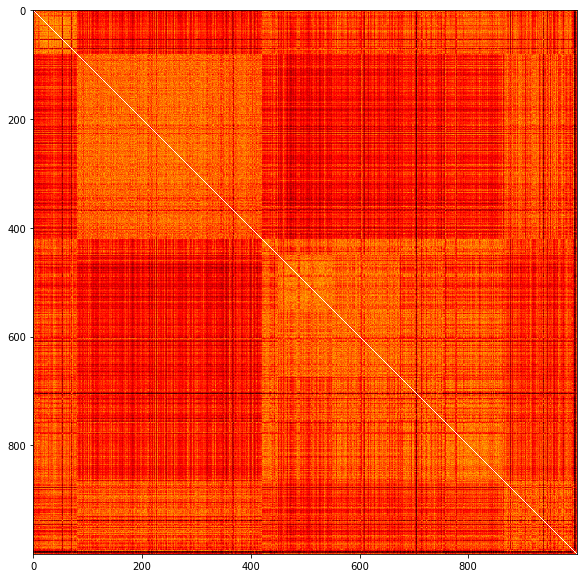

In [13]:
small.heatmap()

In [23]:
pbmc_subset = small.subset('labels',['CD4+/CD45RA+/CD25-_Naive_T', 'CD4+/CD45RO+_Memory',
       'CD4+_T_Helper2', 'CD56+_NK', 'CD8+/CD45RA+_Naive_Cytotoxic'])

computing distances...


array([[0.        , 0.71080969, 0.57455417, ..., 0.65446598, 0.59502779,
        0.65700325],
       [0.71080969, 0.        , 0.70505087, ..., 0.63960591, 0.64018965,
        0.52953239],
       [0.57455417, 0.70505087, 0.        , ..., 0.60263175, 0.65619311,
        0.68552109],
       ...,
       [0.65446598, 0.63960591, 0.60263175, ..., 0.        , 0.63426181,
        0.6069862 ],
       [0.59502779, 0.64018965, 0.65619311, ..., 0.63426181, 0.        ,
        0.69130691],
       [0.65700325, 0.52953239, 0.68552109, ..., 0.6069862 , 0.69130691,
        0.        ]])

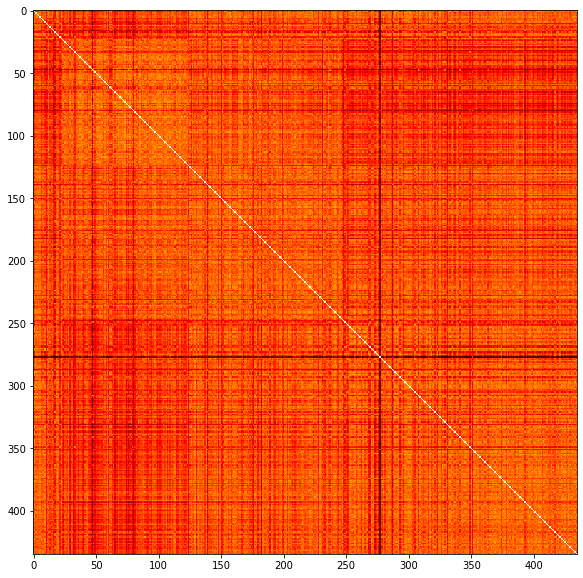

In [15]:
pbmc_subset.heatmap()

In [24]:
pbmc_subset.grow()

making embedding
making embedding
embedding size 435
(435, 3)


interactive(children=(IntSlider(value=218, description='N', max=435, min=1), Dropdown(description='color', opt…

In [25]:
pbmc_subset.pca_dimred(n_components=100)

computing distances...


array([[0.        , 0.38765844, 0.09835892, ..., 0.17720764, 0.15241444,
        0.28740927],
       [0.38765844, 0.        , 0.28929952, ..., 0.21045081, 0.23524401,
        0.10024918],
       [0.09835892, 0.28929952, 0.        , ..., 0.07884871, 0.05405551,
        0.18905035],
       ...,
       [0.17720764, 0.21045081, 0.07884871, ..., 0.        , 0.0247932 ,
        0.11020163],
       [0.15241444, 0.23524401, 0.05405551, ..., 0.0247932 , 0.        ,
        0.13499483],
       [0.28740927, 0.10024918, 0.18905035, ..., 0.11020163, 0.13499483,
        0.        ]])

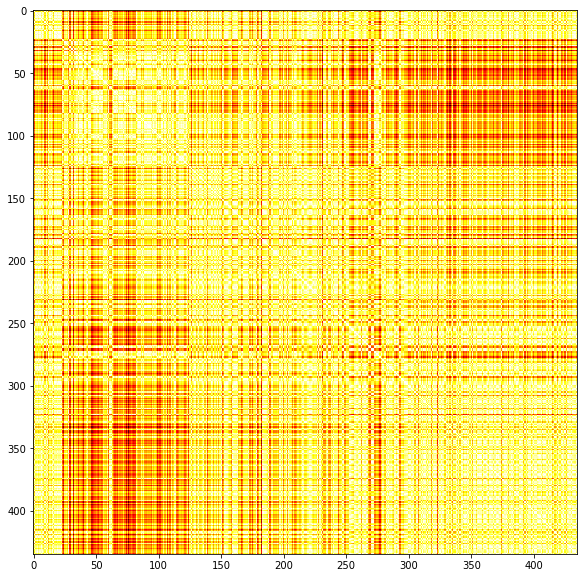

In [27]:
pbmc_subset.heatmap(trunc_euclidean(1))

In [35]:
@interact
def see_hists(col=list(range(pbmc_subset.numFeatures))):
    plt.hist(pbmc_subset.rawdata()[:,col], 30)

interactive(children=(Dropdown(description='col', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [27]:
np.unique(small.data['labels'])

array(['CD14+_Monocyte', 'CD19+_B', 'CD4+/CD25_T_Reg',
       'CD4+/CD45RA+/CD25-_Naive_T', 'CD4+/CD45RO+_Memory',
       'CD4+_T_Helper2', 'CD56+_NK', 'CD8+/CD45RA+_Naive_Cytotoxic',
       'CD8+_Cytotoxic_T', 'Dendritic'], dtype=object)

In [31]:
[np.array([1,2,3]) ==2]

[array([False,  True, False])]

In [40]:
true_labels = [[x==y for x in list(small.data['labels'])] for y in list(small.data['labels'])]

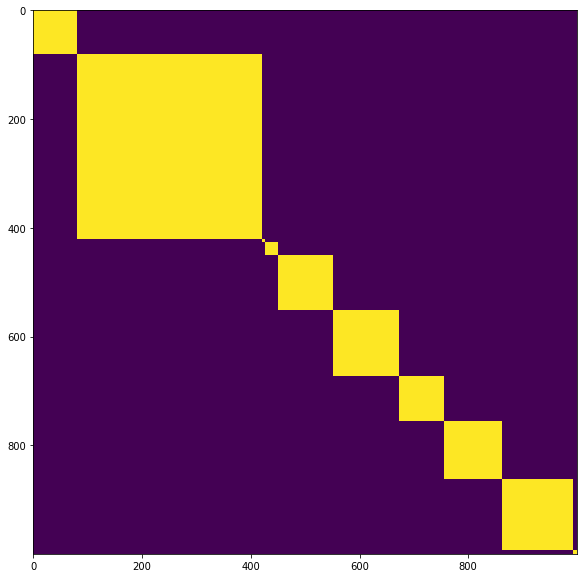

In [41]:
plt.imshow(true_labels)

In [12]:
#is covariance structure different between clusters?
#is it consistent within clusters?
@interact
def cluster_covs(lab = np.unique(pbmc.data['labels'])):
    data = pbmc.subset('labels',lab).rawdata()
    sub1 = data[np.random.choice(data.shape[0], int(data.shape[0]/10), replace=False),:]
    
    n=10
    balls = ball_cover(data, n_balls=n, distfunc=euclidean)[0]
    print({i:len(balls[k]) for i,k in enumerate(list(balls.keys()))})
    @interact
    def ball_covs(ball=(0,n,1)):
        sub = data[balls[list(balls.keys())[ball]],:]
        m = posterior_cov(sub, bayesian=False)
        plt.imshow(np.log(m))
    
#     m = posterior_cov(data, bayesian=False)
#     plt.imshow(np.log(m))
#     m1 = posterior_cov(sub1, bayesian=False)
#     plt.show()
#     plt.imshow(np.log(m1))
#     plt.show()

interactive(children=(Dropdown(description='lab', options=('CD14+_Monocyte', 'CD19+_B', 'CD4+/CD25_T_Reg', 'CD…

In [47]:
#how uniform are epsilon-balls in cluster composition?
balls = ball_cover(pbmc.rawdata(), n_balls=100, distfunc=euclidean)[0]

In [51]:
sizes=[]
pcts=[]
for k in list(balls.keys()):
    sizes.append(len(balls[k]))
    labs = np.array(list(pbmc.data['labels']))[balls[k]]
    
    most_common = max(set(labs),key=list(labs).count)
    occurrences = list(labs).count(most_common)
    pcts.append(float(occurrences)/len(labs))
    
#     counts = dict(Counter(labs))
#     print(Counter(labs))

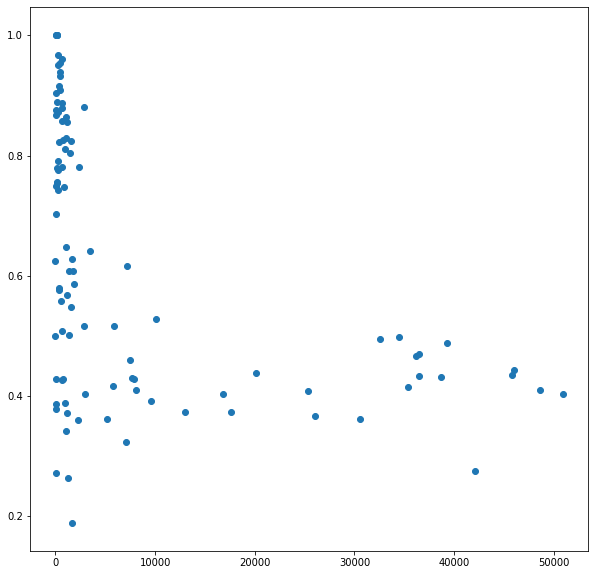

In [56]:
plt.scatter(sizes,pcts)

In [ ]:
#how about knns?

nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(data)
distances, indices = nbrs.kneighbors(data)

In [13]:
def knn_cover(data, subset, subset_inds=None, k=5, metric=euclidean):
#     if subset_inds is None:
#         subset_inds = list(range(data.shape[0]))
    print('Fitting to data...')
    nbrs = NearestNeighbors(n_neighbors=k+1, metric=metric).fit(data)
    
    if subset is None:
        subset = data[subset_inds,:]
    if subset_inds is None:
        subset_inds = list(range(subset.shape[0]))
    
    print('computing neighbors...')
    distances, indices = nbrs.kneighbors(subset)
    
    result = {x:indices[i]  for i,x in enumerate(subset_inds)}
    return(result)
    
    

In [17]:
clust_means = pbmc.data.groupby('labels').mean().values

In [20]:
kdict = {}

for kval in [3, 5, 10, 20, 50, 80, 100]:
    print('processing {}'.format(kval))
    knns = knn_cover(pbmc.rawdata(), subset=clust_means, k=kval, metric=trunc_euclidean(2))
    sizes=[]
    pcts=[]
    for k in list(knns.keys()):
        sizes.append(len(knns[k]))
        labs = np.array(list(pbmc.data['labels']))[knns[k]]

        most_common = max(set(labs),key=list(labs).count)
        occurrences = list(labs).count(most_common)
        pcts.append(float(occurrences)/len(labs))
    kdict[kval] = pcts
    print(kdict)
    

processing 3
Fitting to data...
computing neighbors...
{3: [0.75, 0.75, 0.25, 0.5, 0.75, 1.0, 0.5, 0.75, 0.5, 0.5]}
processing 5
Fitting to data...
computing neighbors...
{3: [0.75, 0.75, 0.25, 0.5, 0.75, 1.0, 0.5, 0.75, 0.5, 0.5], 5: [0.6666666666666666, 0.8333333333333334, 0.5, 0.3333333333333333, 0.5, 0.8333333333333334, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666]}
processing 10
Fitting to data...
computing neighbors...
{3: [0.75, 0.75, 0.25, 0.5, 0.75, 1.0, 0.5, 0.75, 0.5, 0.5], 5: [0.6666666666666666, 0.8333333333333334, 0.5, 0.3333333333333333, 0.5, 0.8333333333333334, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666], 10: [0.45454545454545453, 0.8181818181818182, 0.45454545454545453, 0.36363636363636365, 0.5454545454545454, 0.6363636363636364, 0.36363636363636365, 0.36363636363636365, 0.7272727272727273, 0.7272727272727273]}
processing 20
Fitting to data...
computing neighbors...
{3: [0.75, 0.75, 0.25, 0.5, 0.75, 1.0, 0.5, 0.75, 0.5, 0.5], 5: 

In [21]:
pbmc_small = pbmc.subsamples['ft'][1:100]
pbmc_small.data['k100'] = kdict[100]

ValueError: Length of values does not match length of index

In [115]:
pbmc_small.grow(cmap='hot')

making embedding
making embedding
embedding size 99
(99, 4)


interactive(children=(IntSlider(value=50, description='N', max=99, min=1), Dropdown(description='color', optio…

([<matplotlib.axis.XTick at 0x15757d550>,
 <a list of 7 Text xticklabel objects>)

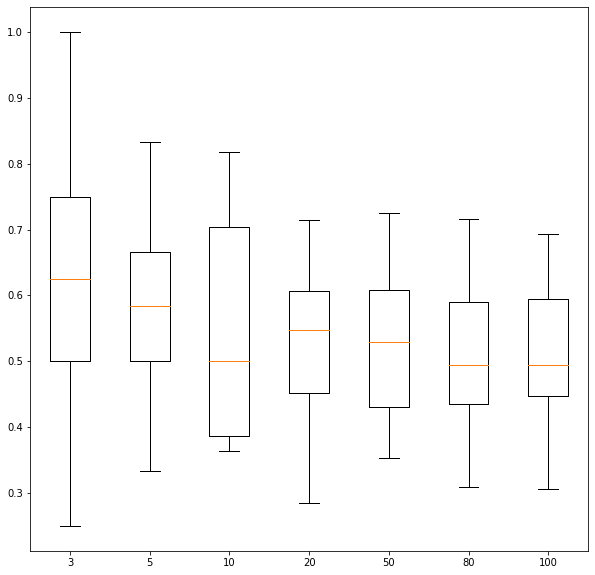

In [22]:
labels, data = kdict.keys(), kdict.values()
plt.boxplot(data)
plt.xticks(range(1,len(labels)+1), labels)

In [104]:
pcts

[0.31683168316831684,
 1.0,
 0.46534653465346537,
 0.9900990099009901,
 0.7326732673267327,
 0.2376237623762376,
 1.0,
 0.7821782178217822,
 0.8217821782178217]

In [27]:
np.random.choice(pbmc.numObs, int(pbmc.numObs/2), replace=False)

array([ 4027, 12824, 20290, ..., 40065, 35232, 23023])

In [25]:
pbmc = pbmc.subsamples['ft'][1:10000]

In [26]:
pbmc.sort_values('labels')

In [30]:
f = fit(np.array(pbmc.data)[:,:pbmc.numFeatures],100, euclidean, bayesian=False)

0.030227581415077854


In [39]:
dists = cov_dist(sorted(f))

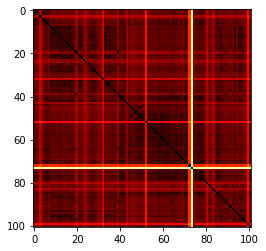

In [43]:
plt.imshow(dists,cmap='hot')

In [13]:
dists=skew_dist(sorted(f))

In [14]:
dists

array([[152.50976797, 138.34108056, 131.86602971, ..., 106.40309843,
        143.72509446,  39.82694349],
       [138.34108056, 164.92576977, 140.23774443, ..., 113.27004306,
        154.48263006,  40.82430132],
       [131.86602971, 140.23774443, 152.66342098, ..., 104.57928383,
        144.84887454,  21.75817019],
       ...,
       [106.40309843, 113.27004306, 104.57928383, ..., 149.13472819,
        124.70771613,  50.75574892],
       [143.72509446, 154.48263006, 144.84887454, ..., 124.70771613,
        180.41939079,  50.49574873],
       [ 39.82694349,  40.82430132,  21.75817019, ...,  50.75574892,
         50.49574873, 195.7352839 ]])

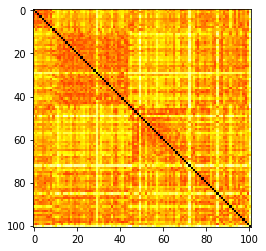

In [18]:
plt.imshow(dists, cmap='hot')

In [15]:
dists=pbmc[[x[0] for x in sorted(f)]].heatmap()

computing distances...


In [19]:
dists

array([[0.        , 0.75920598, 0.62169552, ..., 0.90438011, 0.75202908,
        1.18149545],
       [0.75920598, 0.        , 0.62447193, ..., 0.84831094, 0.62688012,
        1.14306783],
       [0.62169552, 0.62447193, 0.        , ..., 0.85181992, 0.7377215 ,
        1.23055547],
       ...,
       [0.90438011, 0.84831094, 0.85181992, ..., 0.        , 0.7929588 ,
        1.10592636],
       [0.75202908, 0.62688012, 0.7377215 , ..., 0.7929588 , 0.        ,
        1.12342346],
       [1.18149545, 1.14306783, 1.23055547, ..., 1.10592636, 1.12342346,
        0.        ]])

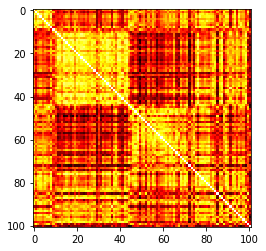

In [21]:
plt.imshow(np.corrcoef(dists), cmap='hot')
plt.show()

In [65]:
pts = np.random.multivariate_normal([0,0],np.identity(2), size=100)

In [89]:
k = knn_cover(pts, k=6)

Fitting to data...


In [13]:
b = ball_cover(pts, 5, euclidean)

In [14]:
f = fit(pts,10, euclidean)

0.7843798966340414
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


In [15]:
f

{5547: (array([-0.23898231,  0.74383465]), array([[0.64522933, 0.01073363],
         [0.01073363, 0.59176232]])),
 8687: (array([ 3.11428074, -2.45167726]), array([[0.2367016 , 0.14157224],
         [0.14157224, 0.3141983 ]])),
 628: (array([-1.47049781, -3.40118194]), array([[ 0.3879208 , -0.08794444],
         [-0.08794444,  0.15929747]])),
 4066: (array([3.62844135, 2.11957306]), array([[ 0.18574199, -0.1035719 ],
         [-0.1035719 ,  0.33609805]])),
 8122: (array([-4.0957647 ,  0.40552859]), array([[0.13425946, 0.02052814],
         [0.02052814, 0.38115163]])),
 646: (array([0.67894634, 3.97373738]), array([[ 0.32558236, -0.0509575 ],
         [-0.0509575 ,  0.13378622]])),
 1720: (array([-1.74136538,  2.91159086]), array([[0.33151825, 0.10312127],
         [0.10312127, 0.21962862]])),
 2619: (array([ 0.59437907, -1.73973752]), array([[0.5352297 , 0.0517818 ],
         [0.0517818 , 0.40781183]])),
 2586: (array([-2.02400495, -0.98136202]), array([[ 0.35435275, -0.07652886],
    

In [73]:

def plot_balls(data, b):
    @interact
    def F(ind=(0,len(b)-1,1)):        
        plt.scatter(data[:,0], data[:,1])
        center = list(b.keys())[ind]
        pts = b[center]
        plt.scatter(data[pts,0], data[pts,1], color='red')
    

In [87]:
def plot_knns(data, nns):
    @interact
    def F(ind=(0,len(nns)-1,1)):        
        plt.scatter(data[:,0], data[:,1])
        center = list(k.keys())[ind]
        pts = k[center]
        plt.scatter(data[pts,0], data[pts,1], color='red')
        plt.scatter(data[center,0],data[center,1],color='purple')
    

In [51]:
gamma(10)

In [252]:
plot_balls(pts,b)

interactive(children=(IntSlider(value=2, description='ind', max=5), Output()), _dom_classes=('widget-interact'…

In [90]:
plot_knns(pts, k)

interactive(children=(IntSlider(value=49, description='ind', max=99), Output()), _dom_classes=('widget-interac…

In [215]:
h = []

In [217]:
heappush(h,2)

In [218]:
h

[2]

In [219]:
heappop(h)

2

In [220]:
h

[]

In [221]:
len(h_)

NameError: name 'h_' is not defined

In [222]:
len(h)

0